# Manuscript Figures
Created by Ivan Lima on Wed Jan 26 2022 10:51:31 -0500

In [1]:
%matplotlib inline
import pandas as pd
import xarray as xr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, datetime, warnings, cmocean
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Thu Apr 21 14:41:12 2022


In [2]:
sns.set_theme(context='paper', style='ticks', palette='tab10', rc={'figure.dpi':100, 'figure.figsize':[5, 5], 'axes.grid':True})
pd.options.display.max_columns = 50
warnings.filterwarnings('ignore')

## Distribution of bottle data 

In [3]:
# read bottle data
df_bottle = pd.read_csv('data/bottle_satellite_data_clean.csv', parse_dates=['Date'], index_col=0)
df_bottle.loc[df_bottle.Date.dt.month.isin([1,2,12]),'season'] = 'Winter' # set seasons
df_bottle.loc[df_bottle.Date.dt.month.isin([3,4,5]),'season'] = 'Spring'
df_bottle.loc[df_bottle.Date.dt.month.isin([6,7,8]),'season'] = 'Summer'
df_bottle.loc[df_bottle.Date.dt.month.isin([9,10,11]),'season'] = 'Fall'

# read bottom topography data
etopo = xr.open_dataset('data/etopo5.nc', chunks='auto')
etopo['bath'] = etopo.bath.where(etopo.bath<0) # ocean points only
etopo = etopo.isel(X=slice(3100,4000), Y=slice(1300,1700)) # subset data to make things faster

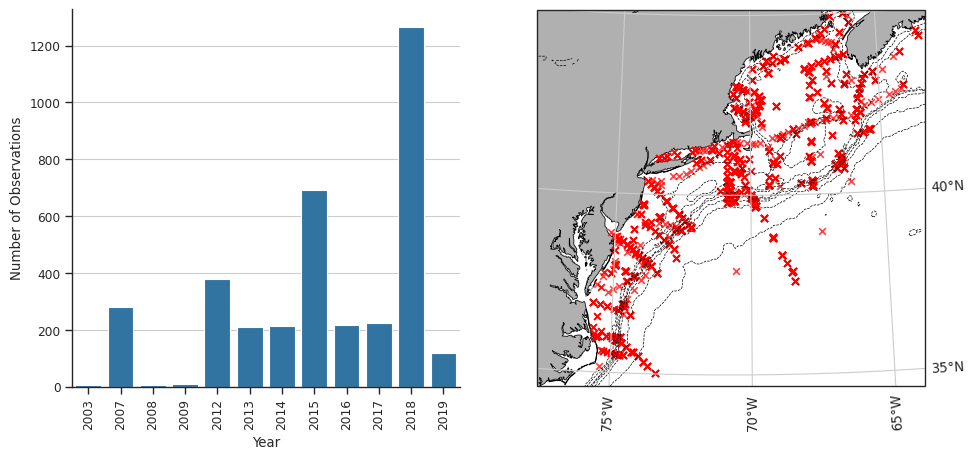

In [4]:
from cartopy import crs as ccrs
from cartopy import feature as cfeature

minlon, maxlon = 282.5, 296
minlat, maxlat =  34.5, 45
lonc, latc = (minlon + maxlon)/2., (minlat + maxlat)/2.
isobaths = [-3000, -2000, -1000, -500, -250, -100, -50]

proj = ccrs.EquidistantConic(central_longitude=lonc, central_latitude=latc)
dpi = 600

s_bottle = df_bottle.groupby('Year')['TA'].count().to_frame().reset_index()

fig = plt.figure(figsize=(11,5))
ax1 = fig.add_subplot(1,2,1)
_ = sns.barplot(data=s_bottle, x='Year', y='TA', color='C0', ax=ax1)
_ = ax1.set_xticklabels(s_bottle.Year, rotation=90)
_ = ax1.set(ylabel='Number of Observations')
sns.despine(fig)
ax2 = fig.add_subplot(1,2,2, projection=proj)
ax2.set_extent([minlon,maxlon,minlat,maxlat])
_ = ax2.add_feature(cfeature.LAND, zorder=1, facecolor='#b0b0b0')
_ = ax2.coastlines(linewidth=0.5, zorder=1)
_ = ax2.gridlines(xlocs=np.arange(-180,180,5),ylocs=np.arange(0,90,5), draw_labels={'bottom': 'x', 'right': 'y'})
sp = ax2.scatter(df_bottle.Longitude, df_bottle.Latitude, c='red', marker='x', transform=ccrs.PlateCarree(), alpha=0.75)
cs = ax2.contour(etopo.X, etopo.Y, etopo.bath, isobaths, colors='k', linewidths=0.5, transform=ccrs.PlateCarree())
# _ = ax2.clabel(cs, isobaths, fontsize=7)
# fig.savefig('figures/bottle_data_distribution.png', dpi=dpi, bbox_inches='tight')

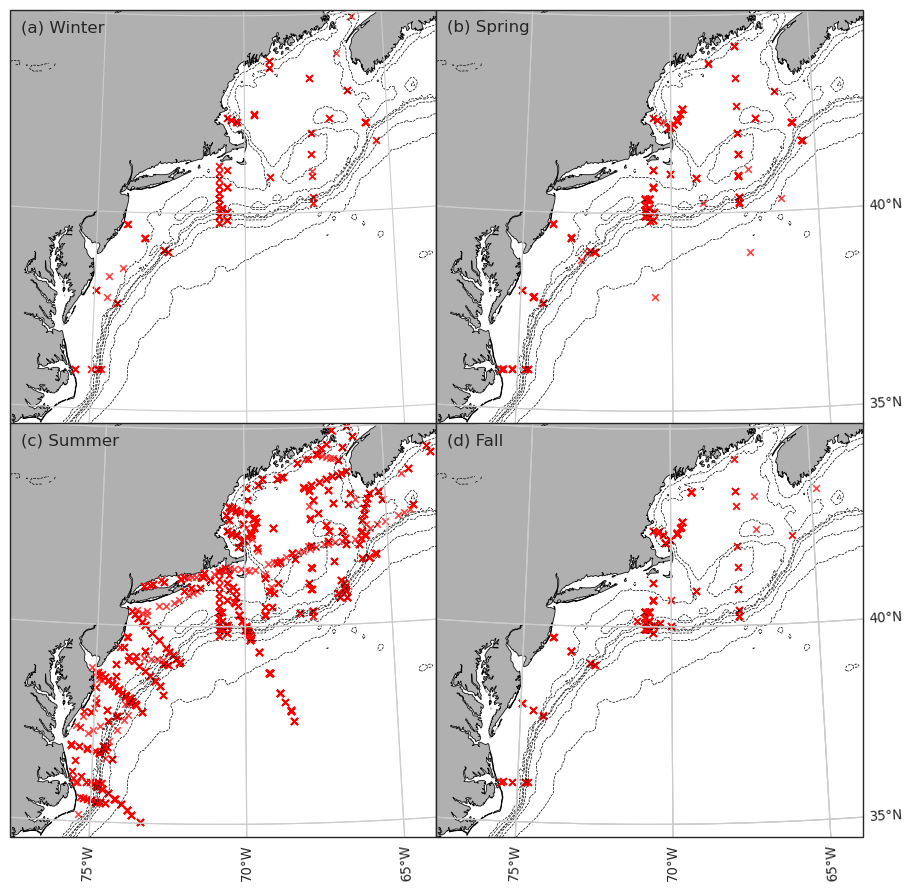

In [5]:
fig, axs = plt.subplots(2, 2, subplot_kw={'projection':proj}, figsize=(11,11))
fig.subplots_adjust(hspace=-0.01, wspace=0)

for ax, s, l in zip(axs.ravel(), ['Winter','Spring','Summer','Fall'], ['(a) ','(b) ','(c) ','(d) ']):
    ax.set_extent([minlon, maxlon, minlat, maxlat])
    _ = ax.add_feature(cfeature.LAND, zorder=1, facecolor='#b0b0b0')
    _ = ax.coastlines(linewidth=0.5, zorder=1)
    _ = ax.gridlines(xlocs=np.arange(-180,180,5),ylocs=np.arange(0,90,5), draw_labels=False)
    _ = ax.contour(etopo.X, etopo.Y, etopo.bath, isobaths, colors='k', linewidths=0.5, transform=ccrs.PlateCarree())
    df = df_bottle[df_bottle.season==s]
    _ = ax.scatter(df.Longitude, df.Latitude, c='red', marker='x', transform=ccrs.PlateCarree(), alpha=0.75)
    _ = ax.text(0.025, 0.975, l + s, ha='left', va='top', transform=ax.transAxes, fontsize=12)

for ax in axs[:,-1]:
    _ = ax.gridlines(xlocs=np.arange(-180,180,5), ylocs=np.arange(0,90,5), draw_labels={'right': 'y'})

for ax in axs[-1,:]:
    _ = ax.gridlines(xlocs=np.arange(-180,180,5), ylocs=np.arange(0,90,5), draw_labels={'bottom': 'x'})

fig.savefig('figures/bottle_data_distribution_seasonal.png', dpi=dpi, bbox_inches='tight')

## Distribution of CTD data 

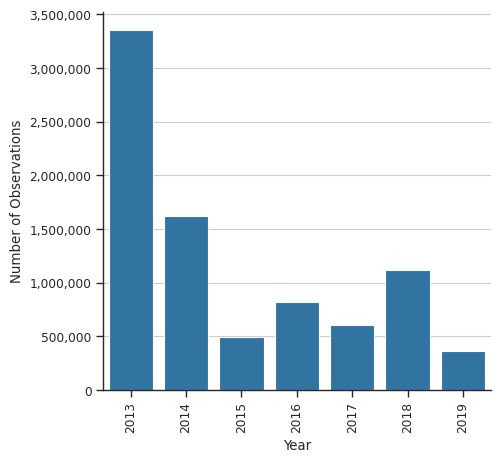

In [6]:
from matplotlib import ticker
fmt = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))

df_wod = pd.read_hdf('data/bgc_all_2013-2019.h5', key='df_wod_bgc')

# convert seasons to uppercase
for s in ['winter','spring','summer','fall']:
    df_wod.loc[df_wod.season==s,'season'] = s.title()

s_ctd = df_wod.groupby(df_wod.Date.dt.year)['TA'].count().to_frame().reset_index()
fig, ax = plt.subplots()
_ = sns.barplot(data=s_ctd, x='Date', y='TA', color='C0', ax=ax)
_ = ax.set_xticklabels(s_ctd.Date, rotation=90)
_ = ax.set(xlabel='Year', ylabel='Number of Observations')
_ = ax.yaxis.set_major_formatter(fmt)
sns.despine(fig)
# fig.savefig('figures/ctd_data_distribution_time.png', dpi=dpi, bbox_inches='tight')

In [7]:
df_ctd = pd.read_csv('data/CombinedCTD_metadata_bathy_600m_sorted.csv', parse_dates=['Date'], index_col=0)
df_ctd = df_ctd[df_ctd.Year>2012]
df_ctd = df_ctd[df_ctd.Longitude<-64.5]  # NELME region
df_ctd = df_ctd[df_ctd.Longitude>-76]    # exclude points in Chesapeake Bay 
df_ctd = df_ctd[df_ctd.Platform_Type!=2] # exclude glider data
df_ctd.loc[df_ctd.Date.dt.month.isin([1,2,12]),'season'] = 'Winter' # set seasons
df_ctd.loc[df_ctd.Date.dt.month.isin([3,4,5]),'season'] = 'Spring'
df_ctd.loc[df_ctd.Date.dt.month.isin([6,7,8]),'season'] = 'Summer'
df_ctd.loc[df_ctd.Date.dt.month.isin([9,10,11]),'season'] = 'Fall'
# df_ctd.head()

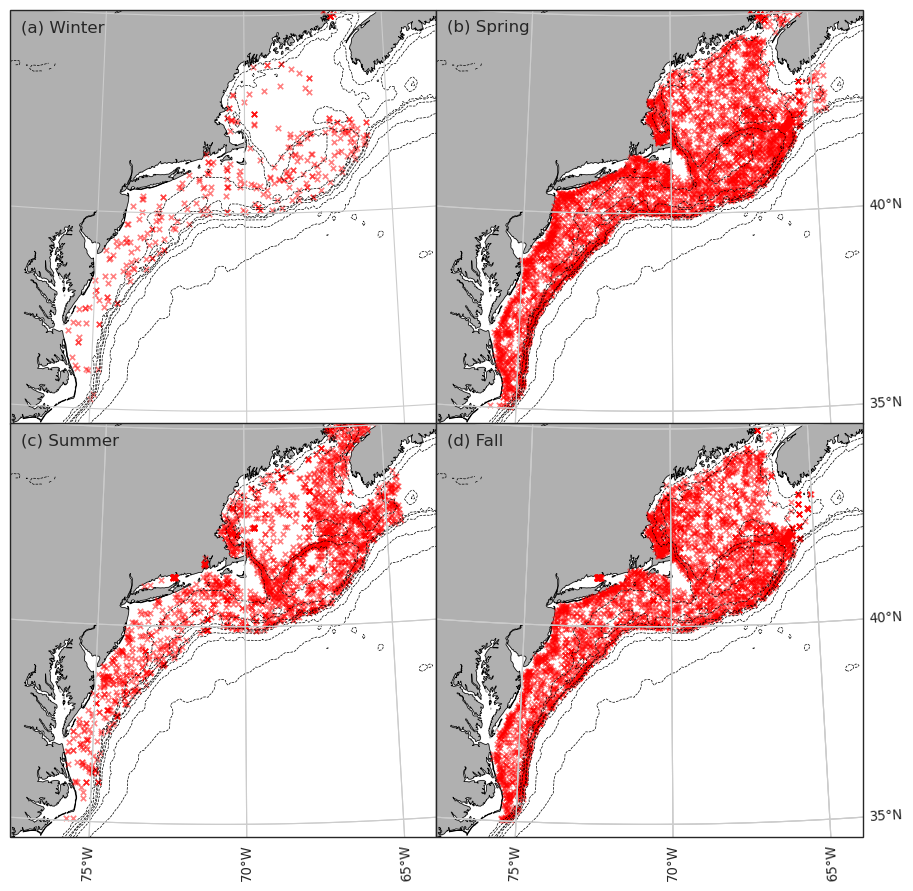

In [8]:
fig, axs = plt.subplots(2, 2, subplot_kw={'projection':proj}, figsize=(11,11))
fig.subplots_adjust(hspace=-0.01, wspace=0)

for ax, s, l in zip(axs.ravel(), ['Winter','Spring','Summer','Fall'], ['(a) ','(b) ','(c) ','(d) ']):
    ax.set_extent([minlon, maxlon, minlat, maxlat])
    _ = ax.add_feature(cfeature.LAND, zorder=1, facecolor='#b0b0b0')
    _ = ax.coastlines(linewidth=0.5, zorder=1)
    _ = ax.gridlines(xlocs=np.arange(-180,180,5),ylocs=np.arange(0,90,5), draw_labels=False)
    _ = ax.contour(etopo.X, etopo.Y, etopo.bath, isobaths, colors='k', linewidths=0.5, transform=ccrs.PlateCarree())
    df = df_ctd[df_ctd.season==s]
    _ = ax.scatter(df.Longitude, df.Latitude, c='red', s=15, marker='x', transform=ccrs.PlateCarree(), alpha=0.5)
    _ = ax.text(0.025, 0.975, l + s, ha='left', va='top', transform=ax.transAxes, fontsize=12)

for ax in axs[:,-1]:
    _ = ax.gridlines(xlocs=np.arange(-180,180,5), ylocs=np.arange(0,90,5), draw_labels={'right': 'y'})

for ax in axs[-1,:]:
    _ = ax.gridlines(xlocs=np.arange(-180,180,5), ylocs=np.arange(0,90,5), draw_labels={'bottom': 'x'})

fig.savefig('figures/ctd_data_distribution_seasonal.png', dpi=dpi, bbox_inches='tight')

In [9]:
# import hvplot.pandas
# import holoviews as hv
# from my_bokeh_themes import *

# # df_ctd.hvplot.points('Longitude', 'Latitude', geo=True, coastline='50m', features={'land':'50m'},
# #                      frame_width=400, rasterize=True)

# p_ctd = hv.Layout()
# for season in ['Winter','Spring','Summer','Fall']:
#     df = df_ctd[df_ctd.season==season]
#     print(season, len(df))
#     p = df.hvplot.points('Longitude', 'Latitude', geo=True, coastline='50m', features={'land':'50m'},
#                          frame_width=400, rasterize=False)
#     p_ctd += p

# p_ctd.cols(2)

## Temporal distribution of bottle & CTD data

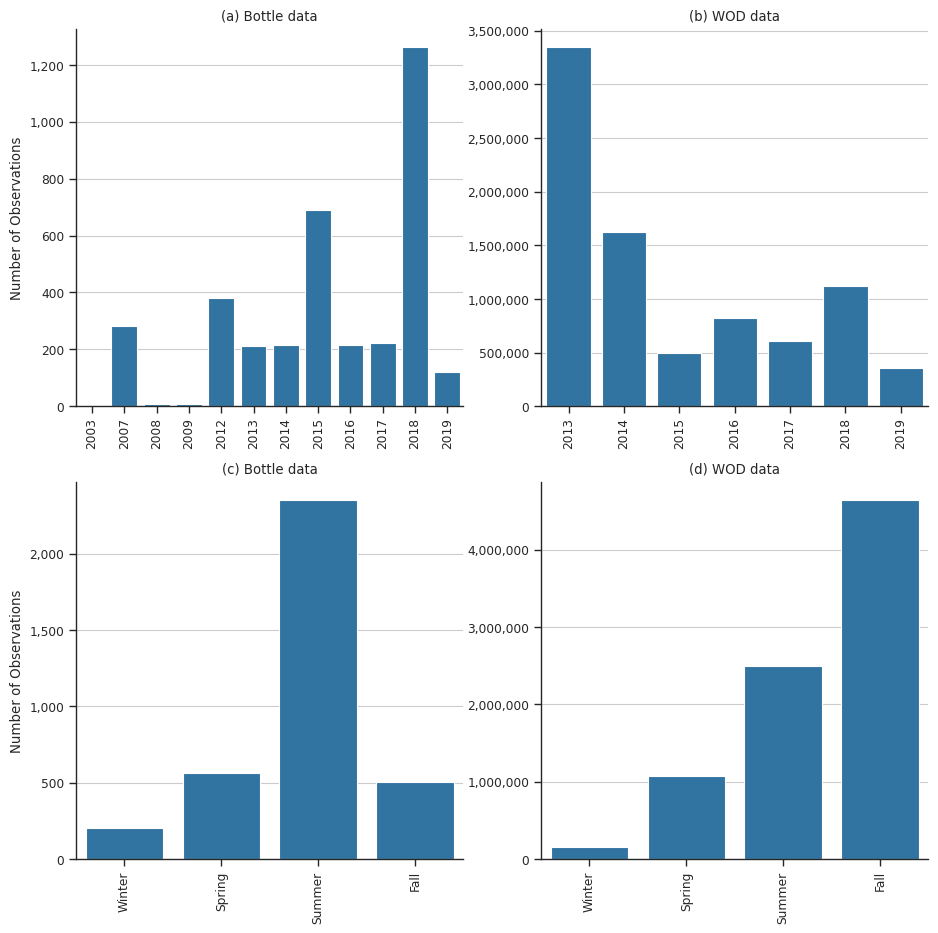

In [10]:
s_bottle = df_bottle.groupby('Year')['TA'].count().to_frame().reset_index()
s_ctd = df_wod.groupby(df_wod.Date.dt.year)['TA'].count().to_frame().reset_index()

seasons = ['Winter','Spring','Summer','Fall']
s_bottle_season = df_bottle.groupby('season')['TA'].count().to_frame().reindex(seasons).reset_index()
s_ctd_season = df_wod.groupby('season')['TA'].count().to_frame().reindex(seasons).reset_index()

fig, axs = plt.subplots(2, 2, figsize=(11, 11))
_ = sns.barplot(data=s_bottle, x='Year', y='TA', color='C0', ax=axs[0,0])
_ = axs[0,0].set_xticklabels(s_bottle.Year, rotation=90)
_ = axs[0,0].set(xlabel='', ylabel='Number of Observations', title='(a) Bottle data')
_ = axs[0,0].yaxis.set_major_formatter(fmt)
_ = sns.barplot(data=s_ctd, x='Date', y='TA', color='C0', ax=axs[0,1])
_ = axs[0,1].set_xticklabels(s_ctd.Date, rotation=90)
_ = axs[0,1].set(xlabel='', ylabel='', title='(b) WOD data')
_ = axs[0,1].yaxis.set_major_formatter(fmt)

_ = sns.barplot(data=s_bottle_season, x='season', y='TA', color='C0', ax=axs[1,0])
_ = axs[1,0].set_xticklabels(seasons, rotation=90)
_ = axs[1,0].set(xlabel='', ylabel='Number of Observations', title='(c) Bottle data')
_ = axs[1,0].yaxis.set_major_formatter(fmt)
_ = sns.barplot(data=s_ctd_season, x='season', y='TA', color='C0', ax=axs[1,1])
_ = axs[1,1].set_xticklabels(seasons, rotation=90)
_ = axs[1,1].set(xlabel='', ylabel='', title='(d) WOD data')
_ = axs[1,1].yaxis.set_major_formatter(fmt)

sns.despine(fig)
fig.savefig('figures/data_distribution_time.png', dpi=dpi, bbox_inches='tight')

## Model accuracy on test set

In [11]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

df_test = pd.read_csv('data/pytorch_bottle_test.csv', index_col=0)
df_test_noO2 = pd.read_csv('data/pytorch_bottle_test_noO2.csv', index_col=0)
df_test_no_sat = pd.read_csv('data/pytorch_bottle_test_no_sat.csv', index_col=0)

true, pred = ['DIC_test','TA_test'], ['DIC_pred_test','TA_pred_test']

r2_vals, rmse_vals = [], []
for df in [df_test, df_test_noO2, df_test_no_sat]:
    r2_vals.append(r2_score(df[true], df[pred]))
    rmse_vals.append(mean_squared_error(df[true], df[pred], squared=False))

stats = pd.DataFrame({'R_squared': r2_vals, 'RMSE': rmse_vals}, index=['all features', '- DO', '- DO - sat'])
print('Combined regression stats for DIC and TA') 
stats.style.format('{:.3f}')

Combined regression stats for DIC and TA


,R_squared,RMSE
all features,0.975,11.350
- DO,0.971,12.004
- DO - sat,0.966,12.929


In [12]:
r2_vals, rmse_vals = [], []
for df in [df_test, df_test_noO2, df_test_no_sat]:
    r2_vals.append(r2_score(df.DIC_test, df.DIC_pred_test))
    rmse_vals.append(mean_squared_error(df.DIC_test, df.DIC_pred_test, squared=False))

stats_dic = pd.DataFrame({'R_squared': r2_vals, 'RMSE': rmse_vals}, index=['all features', '- DO', '- DO - sat'])
print('Regression stats for DIC') 
stats_dic.style.format('{:.3f}')

Regression stats for DIC


,R_squared,RMSE
all features,0.963,14.149
- DO,0.956,15.370
- DO - sat,0.947,16.956


In [13]:
r2_vals, rmse_vals = [], []
for df in [df_test, df_test_noO2, df_test_no_sat]:
    r2_vals.append(r2_score(df.TA_test, df.TA_pred_test))
    rmse_vals.append(mean_squared_error(df.TA_test, df.TA_pred_test, squared=False))

stats_ta = pd.DataFrame({'R_squared': r2_vals, 'RMSE': rmse_vals}, index=['all features', '- DO', '- DO - sat'])
print('Regression stats for TA') 
stats_ta.style.format('{:.3f}')

Regression stats for TA


,R_squared,RMSE
all features,0.987,8.552
- DO,0.987,8.639
- DO - sat,0.986,8.901


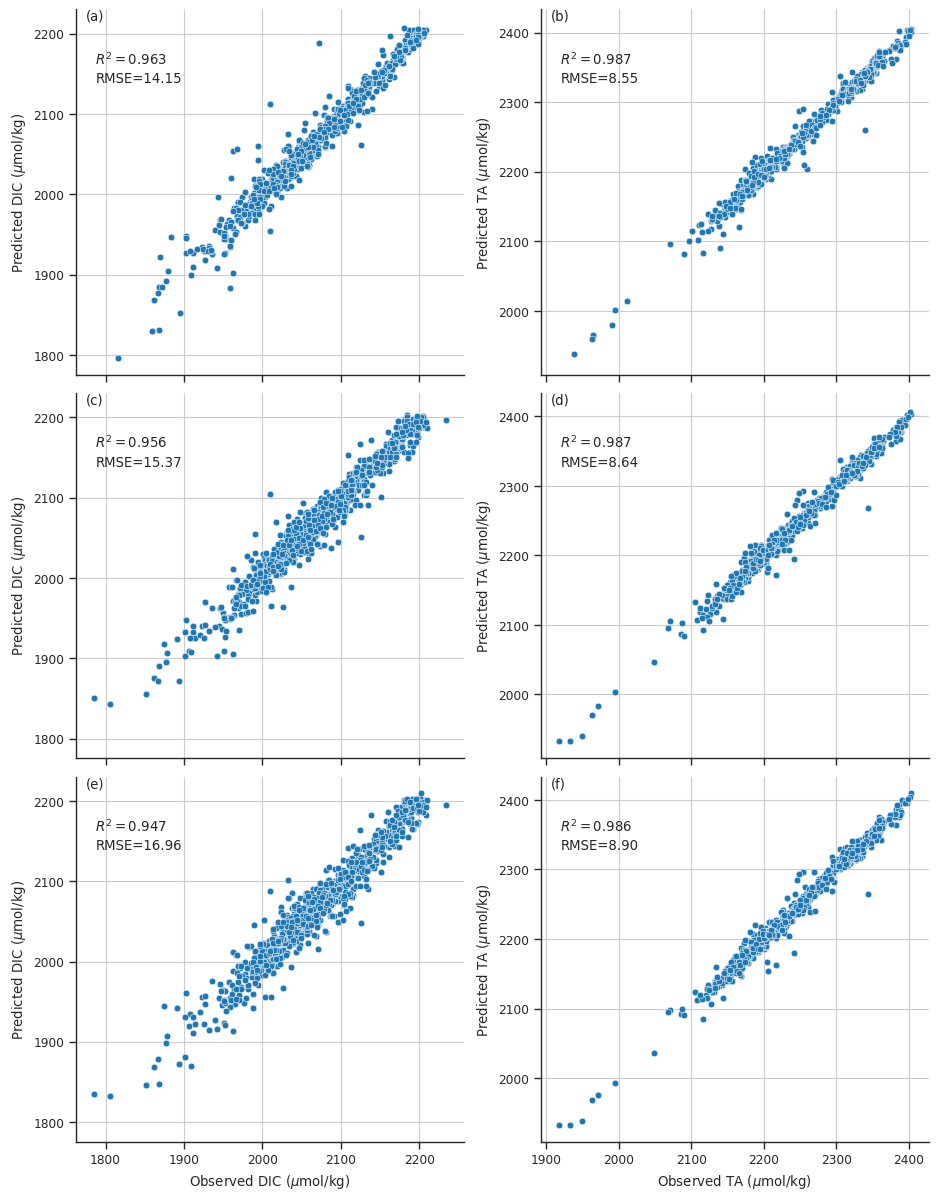

In [14]:
fig, axs = plt.subplots(3, 2, sharex='col', sharey='col', figsize=(11, 15))
fig.subplots_adjust(hspace=0.05)
for df, ax in zip([df_test, df_test_noO2, df_test_no_sat], axs):
    _ = sns.scatterplot(x='DIC_test', y='DIC_pred_test', data=df, ax=ax[0])
    _ = sns.scatterplot(x='TA_test', y='TA_pred_test', data=df, ax=ax[1])

for ax in axs[:,0]:
    ax.set(xlabel='Observed DIC ($\mu$mol/kg)', ylabel='Predicted DIC ($\mu$mol/kg)')
for ax in axs[:,1]:
    ax.set(xlabel='Observed TA ($\mu$mol/kg)', ylabel='Predicted TA ($\mu$mol/kg)')
    
for ax, r2, rmse in zip(axs[:,0], stats_dic.R_squared.values, stats_dic.RMSE.values):
    _ = ax.text(0.05, 0.85, '$R^2={:.3f}$'.format(r2), transform=ax.transAxes, ha='left')
    _ = ax.text(0.05, 0.8, 'RMSE={:.2f}'.format(rmse), transform=ax.transAxes, ha='left')

for ax, r2, rmse in zip(axs[:,1], stats_ta.R_squared.values, stats_ta.RMSE.values):
    _ = ax.text(0.05, 0.85, '$R^2={:.3f}$'.format(r2), transform=ax.transAxes, ha='left')
    _ = ax.text(0.05, 0.8, 'RMSE={:.2f}'.format(rmse), transform=ax.transAxes, ha='left')
    
for ax, label in zip(axs.ravel(), list('abcdef')):
    _ = ax.text(0.025, 0.97, '({})'.format(label), transform=ax.transAxes, ha='left')
    
sns.despine(fig)
fig.savefig('figures/nn_fit_test_set.png', dpi=dpi, bbox_inches='tight')

## Seasonal maps

### Surface fields

In [15]:
ds_surface = xr.open_dataset('data/bgc_surface_seasonal.nc')
ds_surface.data_vars

Data variables:
    Temperature           (season, lat, lon) float64 ...
    Salinity              (season, lat, lon) float64 ...
    DIC                   (season, lat, lon) float64 ...
    TA                    (season, lat, lon) float64 ...
    pH                    (season, lat, lon) float64 ...
    pCO2                  (season, lat, lon) float64 ...
    fCO2                  (season, lat, lon) float64 ...
    saturation_calcite    (season, lat, lon) float64 ...
    saturation_aragonite  (season, lat, lon) float64 ...

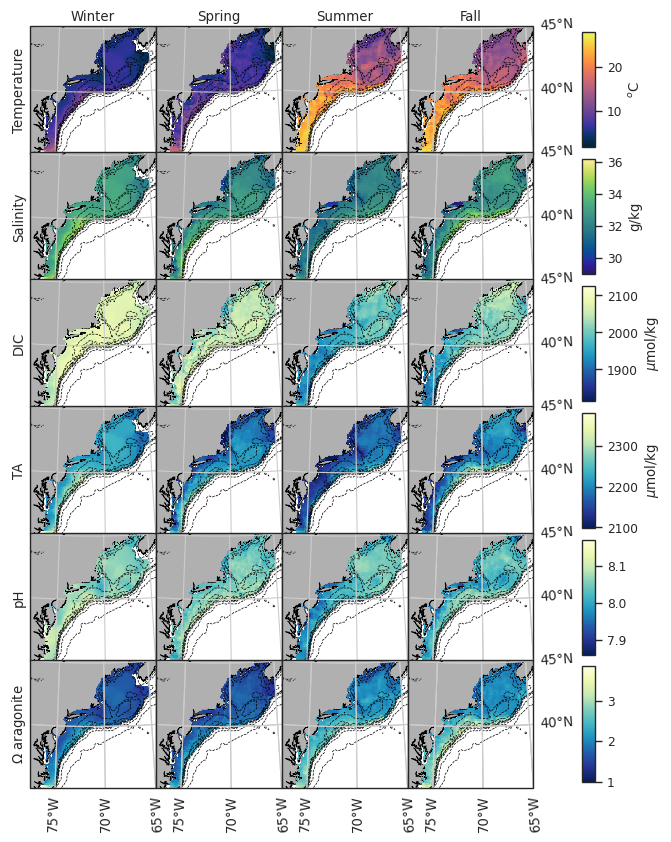

In [16]:
# minlon, maxlon = ds_surface.lon.min().values, ds_surface.lon.max().values
# minlat, maxlat =  ds_surface.lat.min().values, ds_surface.lat.max().values
minlon, maxlon = 282.5-360, ds_surface.lon.max().values
minlat, maxlat =  ds_surface.lat.min().values, 45.1
lonc, latc = (minlon + maxlon)/2., (minlat + maxlat)/2.
proj = ccrs.EquidistantConic(central_longitude=lonc, central_latitude=latc)
cmap = plt.cm.YlGnBu_r

fig, axs = plt.subplots(6, 4, sharex=True, sharey=True, figsize=(6.5, 10.1), subplot_kw={'projection':proj})
fig.subplots_adjust(hspace=-0.01, wspace=0)
for ax in axs.ravel():
    ax.set_extent([minlon, maxlon, minlat, maxlat])
    _ = ax.add_feature(cfeature.LAND, zorder=1, facecolor='#b0b0b0')
    _ = ax.coastlines(linewidth=0.5, zorder=1)
    _ = ax.gridlines(xlocs=np.arange(-180,180,5),ylocs=np.arange(0,90,5), draw_labels=False)
    _ = ax.contour(etopo.X, etopo.Y, etopo.bath, isobaths, colors='k', linewidths=0.5,
                   transform=ccrs.PlateCarree())

for s in range(4):
    tem = axs[0,s].pcolormesh(ds_surface.lon, ds_surface.lat, ds_surface.Temperature.isel(season=s),
                              vmin=1.75, vmax=28, cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree())
    sal = axs[1,s].pcolormesh(ds_surface.lon, ds_surface.lat, ds_surface.Salinity.isel(season=s),
                              vmin=29, vmax=36.2, cmap=cmocean.cm.haline, transform=ccrs.PlateCarree())
    dic = axs[2,s].pcolormesh(ds_surface.lon, ds_surface.lat, ds_surface.DIC.isel(season=s),
                              vmin=1815, vmax=2126, cmap=cmap, transform=ccrs.PlateCarree())
    ta  = axs[3,s].pcolormesh(ds_surface.lon, ds_surface.lat, ds_surface.TA.isel(season=s),
                              vmin=2099, vmax=2381.2, cmap=cmap, transform=ccrs.PlateCarree())
    ph  = axs[4,s].pcolormesh(ds_surface.lon, ds_surface.lat, ds_surface.pH.isel(season=s),
                              vmin=7.86, vmax=8.17, cmap=cmap, transform=ccrs.PlateCarree())
    oa  = axs[5,s].pcolormesh(ds_surface.lon, ds_surface.lat, ds_surface.saturation_aragonite.isel(season=s),
                              vmin=1, vmax=3.85, cmap=cmap, transform=ccrs.PlateCarree())
    # print(oa.get_clim())

# add colorbars
units = [r'$^o$C', 'g/kg', r'$\mu$mol/kg', r'$\mu$mol/kg', '', '']
for ax, pm, u in zip(axs[:,3], [tem, sal, dic, ta, ph, oa], units):
    l, b, w, h = ax.get_position().bounds
    cax = fig.add_axes([l+w+0.075, b+0.05*h, 0.02, h*0.9])
    cb = fig.colorbar(pm, cax=cax)
    cb.set_label(u)

for ax, title in zip(axs[0,:], ['Winter', 'Spring', 'Summer', 'Fall']):
    ax.text(0.5, 1.07, title, ha='center', va='center', transform=ax.transAxes)

for ax, label in zip(axs[:,0], ['Temperature', 'Salinity', 'DIC', 'TA', 'pH', r'$\Omega$ aragonite']):
    ax.text(-0.085, 0.5, label, ha='center', va='center', rotation=90, transform=ax.transAxes)

for ax in axs[:,3]:
    _ = ax.gridlines(xlocs=np.arange(-180,180,5), ylocs=np.arange(0,90,5), draw_labels={'right': 'y'})
    
for ax in axs[5,:]:
    _ = ax.gridlines(xlocs=np.arange(-180,180,5), ylocs=np.arange(0,90,5), draw_labels={'bottom': 'x'})
    
fig.savefig('figures/bgc_surface_seasonal.png', dpi=dpi, bbox_inches='tight')

### Bottom fields

In [17]:
ds_bottom = xr.open_dataset('data/bgc_bottom_seasonal.nc')
ds_bottom.data_vars

Data variables:
    Temperature           (season, lat, lon) float64 ...
    Salinity              (season, lat, lon) float64 ...
    DIC                   (season, lat, lon) float64 ...
    TA                    (season, lat, lon) float64 ...
    pH                    (season, lat, lon) float64 ...
    saturation_calcite    (season, lat, lon) float64 ...
    saturation_aragonite  (season, lat, lon) float64 ...

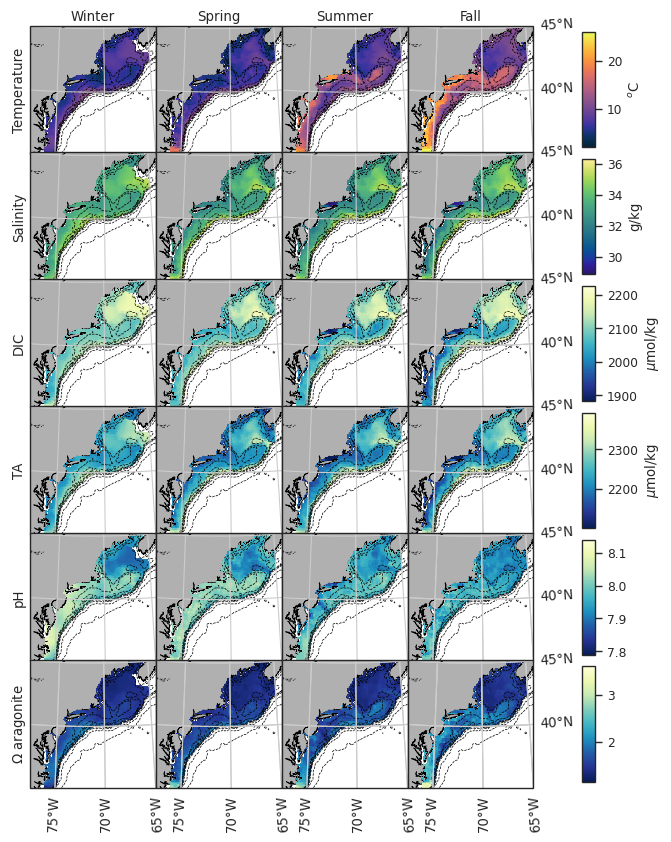

In [18]:
fig, axs = plt.subplots(6, 4, sharex=True, sharey=True, figsize=(6.5, 10.1), subplot_kw={'projection':proj})
fig.subplots_adjust(hspace=-0.01, wspace=0)
for ax in axs.ravel():
    ax.set_extent([minlon, maxlon, minlat, maxlat])
    _ = ax.add_feature(cfeature.LAND, zorder=1, facecolor='#b0b0b0')
    _ = ax.coastlines(linewidth=0.5, zorder=1)
    _ = ax.gridlines(xlocs=np.arange(-180,180,5),ylocs=np.arange(0,90,5), draw_labels=False)
    _ = ax.contour(etopo.X, etopo.Y, etopo.bath, isobaths, colors='k', linewidths=0.5,
                   transform=ccrs.PlateCarree())

for s in range(4):
    tem = axs[0,s].pcolormesh(ds_bottom.lon, ds_bottom.lat, ds_bottom.Temperature.isel(season=s),
                              vmin=2.1, vmax=26, cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree())
    sal = axs[1,s].pcolormesh(ds_bottom.lon, ds_bottom.lat, ds_bottom.Salinity.isel(season=s),
                              vmin=28.9, vmax=36.3, cmap=cmocean.cm.haline, transform=ccrs.PlateCarree())
    dic = axs[2,s].pcolormesh(ds_bottom.lon, ds_bottom.lat, ds_bottom.DIC.isel(season=s),
                              vmin=1883.1, vmax=2227.85, cmap=cmap, transform=ccrs.PlateCarree())
    ta  = axs[3,s].pcolormesh(ds_bottom.lon, ds_bottom.lat, ds_bottom.TA.isel(season=s),
                              vmin=2102, vmax=2392.93, cmap=cmap, transform=ccrs.PlateCarree())
    ph  = axs[4,s].pcolormesh(ds_bottom.lon, ds_bottom.lat, ds_bottom.pH.isel(season=s),
                              vmin=7.79, vmax=8.14, cmap=cmap, transform=ccrs.PlateCarree())
    oa  = axs[5,s].pcolormesh(ds_bottom.lon, ds_bottom.lat, ds_bottom.saturation_aragonite.isel(season=s),
                              vmin=1.15, vmax=3.6, cmap=cmap, transform=ccrs.PlateCarree())
    # print(oa.get_clim())

# add colorbars
units = [r'$^o$C', 'g/kg', r'$\mu$mol/kg', r'$\mu$mol/kg', '', '']
for ax, pm, u in zip(axs[:,3], [tem, sal, dic, ta, ph, oa], units):
    l, b, w, h = ax.get_position().bounds
    cax = fig.add_axes([l+w+0.075, b+0.05*h, 0.02, h*0.9])
    cb = fig.colorbar(pm, cax=cax)
    cb.set_label(u)

for ax, title in zip(axs[0,:], ['Winter', 'Spring', 'Summer', 'Fall']):
    ax.text(0.5, 1.07, title, ha='center', va='center', transform=ax.transAxes)

for ax, label in zip(axs[:,0], ['Temperature', 'Salinity', 'DIC', 'TA', 'pH', r'$\Omega$ aragonite']):
    ax.text(-0.085, 0.5, label, ha='center', va='center', rotation=90, transform=ax.transAxes)

for ax in axs[:,3]:
    _ = ax.gridlines(xlocs=np.arange(-180,180,5), ylocs=np.arange(0,90,5), draw_labels={'right': 'y'})
    
for ax in axs[5,:]:
    _ = ax.gridlines(xlocs=np.arange(-180,180,5), ylocs=np.arange(0,90,5), draw_labels={'bottom': 'x'})
    
fig.savefig('figures/bgc_bottom_seasonal.png', dpi=dpi, bbox_inches='tight')

### Surface - Bottom

In [19]:
ds_diff = ds_surface - ds_bottom

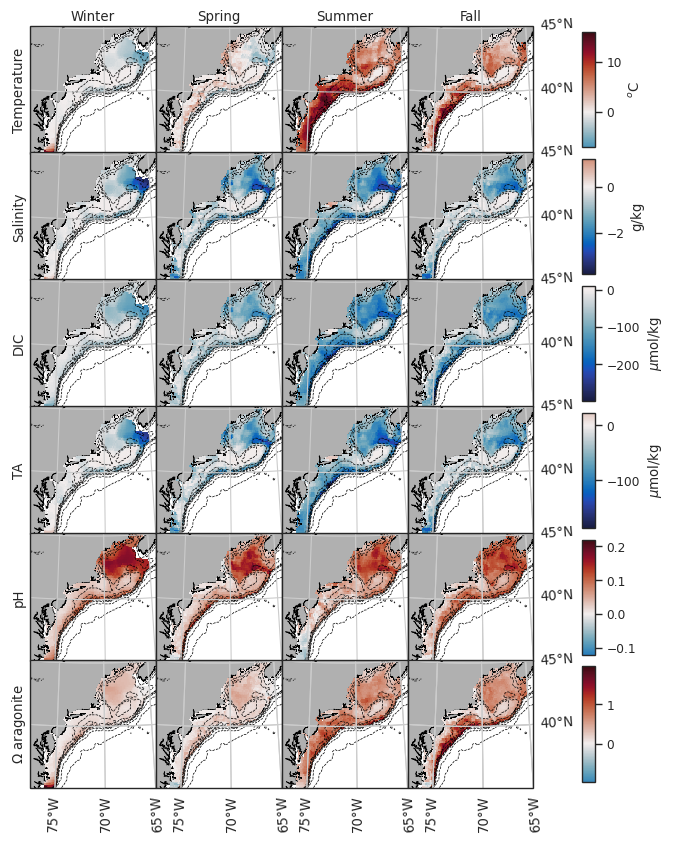

In [20]:
from matplotlib import colors
from mpl_utils import center_cmap

fig, axs = plt.subplots(6, 4, sharex=True, sharey=True, figsize=(6.5, 10.1), subplot_kw={'projection':proj})
fig.subplots_adjust(hspace=-0.01, wspace=0)
for ax in axs.ravel():
    ax.set_extent([minlon, maxlon, minlat, maxlat])
    _ = ax.add_feature(cfeature.LAND, zorder=1, facecolor='#b0b0b0')
    _ = ax.coastlines(linewidth=0.5, zorder=1)
    _ = ax.gridlines(xlocs=np.arange(-180,180,5),ylocs=np.arange(0,90,5), draw_labels=False)
    _ = ax.contour(etopo.X, etopo.Y, etopo.bath, isobaths, colors='k', linewidths=0.5,
                   transform=ccrs.PlateCarree())

for s in range(4):
    tem = axs[0,s].pcolormesh(ds_diff.lon, ds_diff.lat, ds_diff.Temperature.isel(season=s),
                              vmin=-7, vmax=16, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())
    sal = axs[1,s].pcolormesh(ds_diff.lon, ds_diff.lat, ds_diff.Salinity.isel(season=s),
                              vmin=-3.8, vmax=1.23, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())
    dic = axs[2,s].pcolormesh(ds_diff.lon, ds_diff.lat, ds_diff.DIC.isel(season=s),
                              vmin=-299, vmax=11.15, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())
    ta  = axs[3,s].pcolormesh(ds_diff.lon, ds_diff.lat, ds_diff.TA.isel(season=s),
                              vmin=-185.9, vmax=22.76, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())
    ph  = axs[4,s].pcolormesh(ds_diff.lon, ds_diff.lat, ds_diff.pH.isel(season=s),
                              vmin=-0.12, vmax=0.22, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())
    oa  = axs[5,s].pcolormesh(ds_diff.lon, ds_diff.lat, ds_diff.saturation_aragonite.isel(season=s),
                              vmin=-0.96, vmax=1.96, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())
    # print(oa.get_clim())
    for pm in [tem, sal, dic, ta, ph, oa]:
        center_cmap(pm)

# add colorbars
units = [r'$^o$C', 'g/kg', r'$\mu$mol/kg', r'$\mu$mol/kg', '', '']
for ax, pm, u in zip(axs[:,3], [tem, sal, dic, ta, ph, oa], units):
    l, b, w, h = ax.get_position().bounds
    cax = fig.add_axes([l+w+0.075, b+0.05*h, 0.02, h*0.9])
    cb = fig.colorbar(pm, cax=cax)
    cb.set_label(u)

for ax, title in zip(axs[0,:], ['Winter', 'Spring', 'Summer', 'Fall']):
    ax.text(0.5, 1.07, title, ha='center', va='center', transform=ax.transAxes)

for ax, label in zip(axs[:,0], ['Temperature', 'Salinity', 'DIC', 'TA', 'pH', r'$\Omega$ aragonite']):
    ax.text(-0.085, 0.5, label, ha='center', va='center', rotation=90, transform=ax.transAxes)

for ax in axs[:,3]:
    _ = ax.gridlines(xlocs=np.arange(-180,180,5), ylocs=np.arange(0,90,5), draw_labels={'right': 'y'})
    
for ax in axs[5,:]:
    _ = ax.gridlines(xlocs=np.arange(-180,180,5), ylocs=np.arange(0,90,5), draw_labels={'bottom': 'x'})
    
fig.savefig('figures/bgc_difference_seasonal.png', dpi=dpi, bbox_inches='tight')

## Model uncertainty

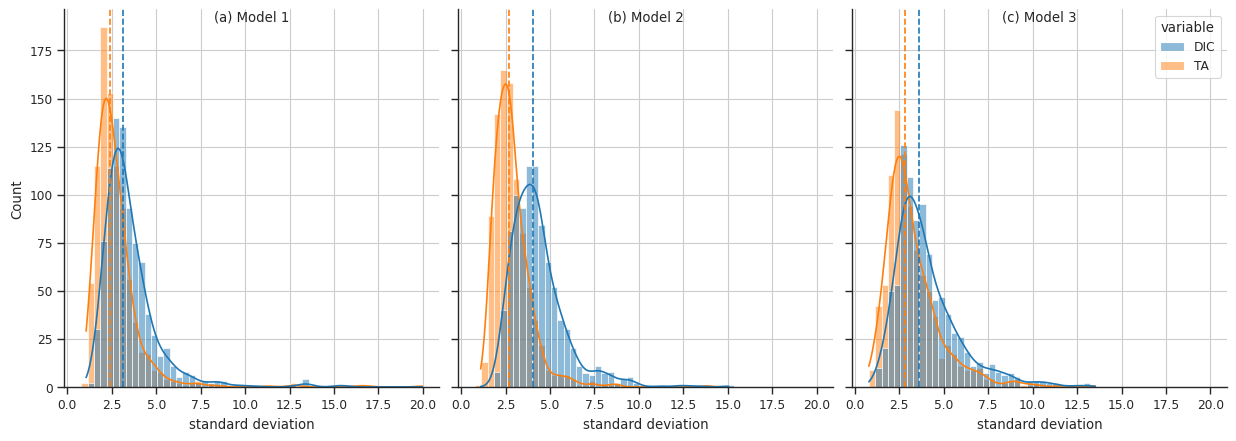

In [21]:
df_uncert = pd.read_csv('data/uncertainty_testset.csv', index_col=0)
df_uncert_noO2 = pd.read_csv('data/uncertainty_testset_noO2.csv', index_col=0)
df_uncert_no_sat = pd.read_csv('data/uncertainty_testset_no_sat.csv', index_col=0)

std_min = np.min([df_uncert.std_DIC.min(), df_uncert.std_TA.min(),
                  df_uncert_noO2.std_DIC.min(), df_uncert_noO2.std_TA.min(),
                  df_uncert_no_sat.std_DIC.min(), df_uncert_no_sat.std_TA.min()])

std_max = np.max([df_uncert.std_DIC.max(), df_uncert.std_TA.max(),
                  df_uncert_noO2.std_DIC.max(), df_uncert_noO2.std_TA.max(),
                  df_uncert_no_sat.std_DIC.max(), df_uncert_no_sat.std_TA.max()])

def reformat(df_in):
    df_work = df_in[['std_DIC','std_TA']].rename(columns={'std_DIC':'DIC','std_TA':'TA'}).stack().reset_index(level=1)
    df_out = df_work.rename(columns={'level_1':'variable', 0:'std'}).reset_index(drop=True)
    return df_out

df1 = reformat(df_uncert)
df2 = reformat(df_uncert_noO2)
df3 = reformat(df_uncert_no_sat)

mdic = [df.std_DIC.median() for df in [df_uncert, df_uncert_noO2, df_uncert_no_sat]]
mta = [df.std_TA.median() for df in [df_uncert, df_uncert_noO2, df_uncert_no_sat]]

# bins = np.histogram_bin_edges(df1['std'], bins='auto')
bins = np.linspace(std_min, std_max, 55)

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))
fig.subplots_adjust(wspace=0.05)
for ax, df, leg, md, ma in zip(axs.ravel(), [df1, df2, df3], [False, False, True], mdic, mta):
    _ = sns.histplot(x='std', data=df, hue='variable', kde=True, bins=bins, ax=ax, legend=leg)
    _ = ax.set(xlabel='standard deviation')
    _ = ax.axvline(md, c='C0', ls='--')
    _ = ax.axvline(ma, c='C1', ls='--')
    
for ax, lab in zip(axs.ravel(), ['(a) Model 1', '(b) Model 2', '(c) Model 3']):
    _ = ax.text(0.5, 0.97, '{}'.format(lab), transform=ax.transAxes, ha='center')
sns.despine(fig)
# fig.savefig('figures/model_uncertainty.png', dpi=dpi, bbox_inches='tight')

In [22]:
dic_std = [
    [df_uncert.std_DIC.min(), df_uncert.std_DIC.max(), df_uncert.std_DIC.median()],
    [df_uncert_noO2.std_DIC.min(), df_uncert_noO2.std_DIC.max(), df_uncert_noO2.std_DIC.median()],
    [df_uncert_no_sat.std_DIC.min(), df_uncert_no_sat.std_DIC.max(), df_uncert_no_sat.std_DIC.median()]
]
pd.DataFrame(dic_std, columns=['DIC $\sigma$ min','DIC $\sigma$ max','DIC $\sigma$ median'],
             index=['Model 1', 'Model 2', 'Model 3']).style.format('{:.3f}')

,DIC $\sigma$ min,DIC $\sigma$ max,DIC $\sigma$ median
Model 1,1.460,15.462,3.136
Model 2,1.950,15.053,4.051
Model 3,1.294,13.091,3.613


In [23]:
ta_std = [
    [df_uncert.std_TA.min(), df_uncert.std_TA.max(), df_uncert.std_TA.median()],
    [df_uncert_noO2.std_TA.min(), df_uncert_noO2.std_TA.max(), df_uncert_noO2.std_TA.median()],
    [df_uncert_no_sat.std_TA.min(), df_uncert_no_sat.std_TA.max(), df_uncert_no_sat.std_TA.median()]
]
pd.DataFrame(ta_std, columns=['TA $\sigma$ min','TA $\sigma$ max','TA $\sigma$ median'],
             index=['Model 1', 'Model 2', 'Model 3']).style.format('{:.3f}')

,TA $\sigma$ min,TA $\sigma$ max,TA $\sigma$ median
Model 1,1.057,19.966,2.417
Model 2,1.100,13.852,2.669
Model 3,0.789,13.527,2.833


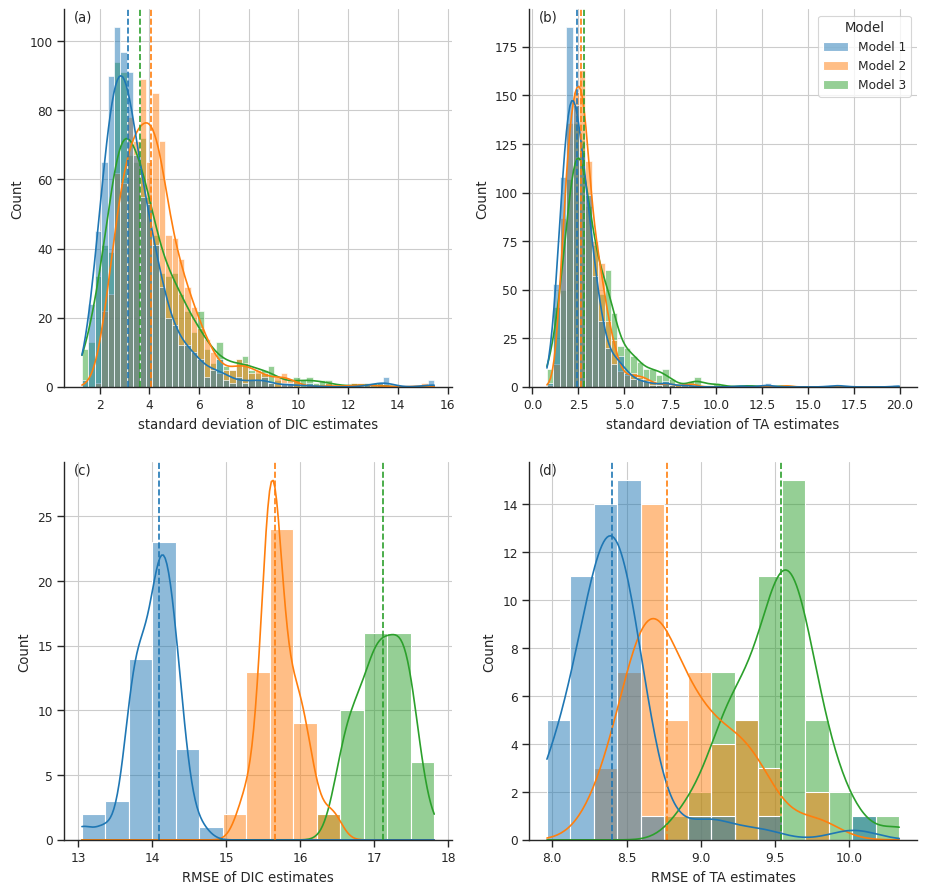

In [24]:
df_ensemble = pd.read_csv('data/ensemble_testset.csv', index_col=0)
df_ensemble_noO2 = pd.read_csv('data/ensemble_testset_noO2.csv', index_col=0)
df_ensemble_no_sat = pd.read_csv('data/ensemble_testset_no_sat.csv', index_col=0)

df_ensemble_dic = pd.DataFrame({'Model 1': df_ensemble.rmse_DIC, 'Model 2': df_ensemble_noO2.rmse_DIC, 'Model 3': df_ensemble_no_sat.rmse_DIC})
df_ensemble_ta = pd.DataFrame({'Model 1': df_ensemble.rmse_TA, 'Model 2': df_ensemble_noO2.rmse_TA, 'Model 3': df_ensemble_no_sat.rmse_TA})

df_ensemble_dic = pd.melt(df_ensemble_dic, value_vars=['Model 1','Model 2','Model 3']).rename(columns={'variable':'Model', 'value':'RMSE'})
df_ensemble_ta = pd.melt(df_ensemble_ta, value_vars=['Model 1','Model 2','Model 3']).rename(columns={'variable':'Model', 'value':'RMSE'})

m_ens_dic = [df.rmse_DIC.median() for df in [df_ensemble, df_ensemble_noO2, df_ensemble_no_sat]]
m_ens_ta = [df.rmse_TA.median() for df in [df_ensemble, df_ensemble_noO2, df_ensemble_no_sat]]

df_dic = pd.DataFrame({'Model 1': df_uncert['std_DIC'], 'Model 2': df_uncert_noO2['std_DIC'],
                       'Model 3': df_uncert_no_sat['std_DIC']})
df_ta = pd.DataFrame({'Model 1': df_uncert['std_TA'], 'Model 2': df_uncert_noO2['std_TA'],
                      'Model 3': df_uncert_no_sat['std_TA']})

df_dic = pd.melt(df_dic, value_vars=['Model 1','Model 2','Model 3']).rename(columns={'variable':'Model', 'value':'std'})
df_ta = pd.melt(df_ta, value_vars=['Model 1','Model 2','Model 3']).rename(columns={'variable':'Model', 'value':'std'})

fig, axs = plt.subplots(2, 2, figsize=(11, 11))
_ = sns.histplot(x='std', data=df_dic, hue='Model', kde=True, bins=55, ax=axs[0,0], legend=False)
_ = sns.histplot(x='std', data=df_ta, hue='Model', kde=True, bins=55, ax=axs[0,1], legend=True)
_ = sns.histplot(x='RMSE', data=df_ensemble_dic, hue='Model', kde=True, bins=15, ax=axs[1,0], legend=False)
_ = sns.histplot(x='RMSE', data=df_ensemble_ta, hue='Model', kde=True, bins=15, ax=axs[1,1], legend=False)
for md, c in zip(mdic, ['C0','C1','C2']):
    _ = axs[0,0].axvline(md, c=c, ls='--')
for md, c in zip(mta, ['C0','C1','C2']):
    _ = axs[0,1].axvline(md, c=c, ls='--')
for md, c in zip(m_ens_dic, ['C0','C1','C2']):
    _ = axs[1,0].axvline(md, c=c, ls='--')
for md, c in zip(m_ens_ta, ['C0','C1','C2']):
    _ = axs[1,1].axvline(md, c=c, ls='--')
for ax, lab in zip(axs.ravel(), ['(a)', '(b)', '(c)', '(d)']):
    _ = ax.text(0.025, 0.97, '{}'.format(lab), transform=ax.transAxes, ha='left')
_ = axs[0,0].set(xlabel='standard deviation of DIC estimates')
_ = axs[0,1].set(xlabel='standard deviation of TA estimates')
_ = axs[1,0].set(xlabel='RMSE of DIC estimates')
_ = axs[1,1].set(xlabel='RMSE of TA estimates')
sns.despine(fig)
fig.savefig('figures/model_uncertainty.png', dpi=dpi, bbox_inches='tight')

In [25]:
dic_rmse = [
    [df_ensemble.rmse_DIC.min(), df_ensemble.rmse_DIC.max(), df_ensemble.rmse_DIC.median()],
    [df_ensemble_noO2.rmse_DIC.min(), df_ensemble_noO2.rmse_DIC.max(), df_ensemble_noO2.rmse_DIC.median()],
    [df_ensemble_no_sat.rmse_DIC.min(), df_ensemble_no_sat.rmse_DIC.max(), df_ensemble_no_sat.rmse_DIC.median()]
]
pd.DataFrame(dic_rmse, columns=['DIC RMSE min','DIC RMSE max','DIC RMSE median'],
             index=['Model 1', 'Model 2', 'Model 3']).style.format('{:.3f}')

,DIC RMSE min,DIC RMSE max,DIC RMSE median
Model 1,13.052,14.646,14.094
Model 2,15.190,16.476,15.661
Model 3,16.489,17.807,17.117


In [26]:
ta_rmse = [
    [df_ensemble.rmse_TA.min(), df_ensemble.rmse_TA.max(), df_ensemble.rmse_TA.median()],
    [df_ensemble_noO2.rmse_TA.min(), df_ensemble_noO2.rmse_TA.max(), df_ensemble_noO2.rmse_TA.median()],
    [df_ensemble_no_sat.rmse_TA.min(), df_ensemble_no_sat.rmse_TA.max(), df_ensemble_no_sat.rmse_TA.median()]
]
pd.DataFrame(ta_rmse, columns=['TA RMSE min','TA RMSE max','TA RMSE median'],
             index=['Model 1', 'Model 2', 'Model 3']).style.format('{:.3f}')

,TA RMSE min,TA RMSE max,TA RMSE median
Model 1,7.964,10.028,8.400
Model 2,8.328,9.774,8.771
Model 3,8.895,10.336,9.539


### $R^2$

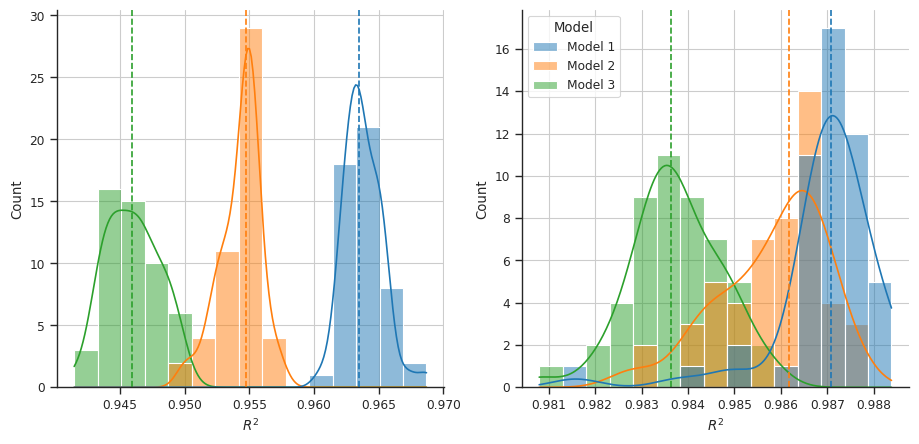

In [38]:
df_ensemble_dic2 = pd.DataFrame({'Model 1': df_ensemble.r2_DIC, 'Model 2': df_ensemble_noO2.r2_DIC, 'Model 3': df_ensemble_no_sat.r2_DIC})
df_ensemble_ta2 = pd.DataFrame({'Model 1': df_ensemble.r2_TA, 'Model 2': df_ensemble_noO2.r2_TA, 'Model 3': df_ensemble_no_sat.r2_TA})

df_ensemble_dic2 = pd.melt(df_ensemble_dic2, value_vars=['Model 1','Model 2','Model 3']).rename(columns={'variable':'Model', 'value':'$R^2$'})
df_ensemble_ta2 = pd.melt(df_ensemble_ta2, value_vars=['Model 1','Model 2','Model 3']).rename(columns={'variable':'Model', 'value':'$R^2$'})

m_ens_dic2 = [df.r2_DIC.median() for df in [df_ensemble, df_ensemble_noO2, df_ensemble_no_sat]]
m_ens_ta2 = [df.r2_TA.median() for df in [df_ensemble, df_ensemble_noO2, df_ensemble_no_sat]]

fig, axs = plt.subplots(1, 2, figsize=(11, 5))
_ = sns.histplot(x='$R^2$', data=df_ensemble_dic2, hue='Model', kde=True, bins=15, ax=axs[0], legend=False)
_ = sns.histplot(x='$R^2$', data=df_ensemble_ta2, hue='Model', kde=True, bins=15, ax=axs[1], legend=True)
for md, c in zip(m_ens_dic2, ['C0','C1','C2']):
    _ = axs[0].axvline(md, c=c, ls='--')
for md, c in zip(m_ens_ta2, ['C0','C1','C2']):
    _ = axs[1].axvline(md, c=c, ls='--')
sns.despine(fig)

In [39]:
dic_r2 = [
    [df_ensemble.r2_DIC.min(), df_ensemble.r2_DIC.max(), df_ensemble.r2_DIC.median()],
    [df_ensemble_noO2.r2_DIC.min(), df_ensemble_noO2.r2_DIC.max(), df_ensemble_noO2.r2_DIC.median()],
    [df_ensemble_no_sat.r2_DIC.min(), df_ensemble_no_sat.r2_DIC.max(), df_ensemble_no_sat.r2_DIC.median()]
]
pd.DataFrame(dic_r2, columns=['DIC $R^2$ min','DIC $R^2$ max','DIC $R^2$ median'],
             index=['Model 1', 'Model 2', 'Model 3']).style.format('{:.3f}')

,DIC $R^2$ min,DIC $R^2$ max,DIC $R^2$ median
Model 1,0.961,0.969,0.963
Model 2,0.950,0.957,0.955
Model 3,0.941,0.950,0.946


In [40]:
ta_r2 = [
    [df_ensemble.r2_TA.min(), df_ensemble.r2_TA.max(), df_ensemble.r2_TA.median()],
    [df_ensemble_noO2.r2_TA.min(), df_ensemble_noO2.r2_TA.max(), df_ensemble_noO2.r2_TA.median()],
    [df_ensemble_no_sat.r2_TA.min(), df_ensemble_no_sat.r2_TA.max(), df_ensemble_no_sat.r2_TA.median()]
]
pd.DataFrame(ta_r2, columns=['TA $R^2$ min','TA $R^2$ max','TA $R^2$ median'],
             index=['Model 1', 'Model 2', 'Model 3']).style.format('{:.3f}')

,TA $R^2$ min,TA $R^2$ max,TA $R^2$ median
Model 1,0.982,0.988,0.987
Model 2,0.983,0.988,0.986
Model 3,0.981,0.986,0.984


### Coefficient of variation

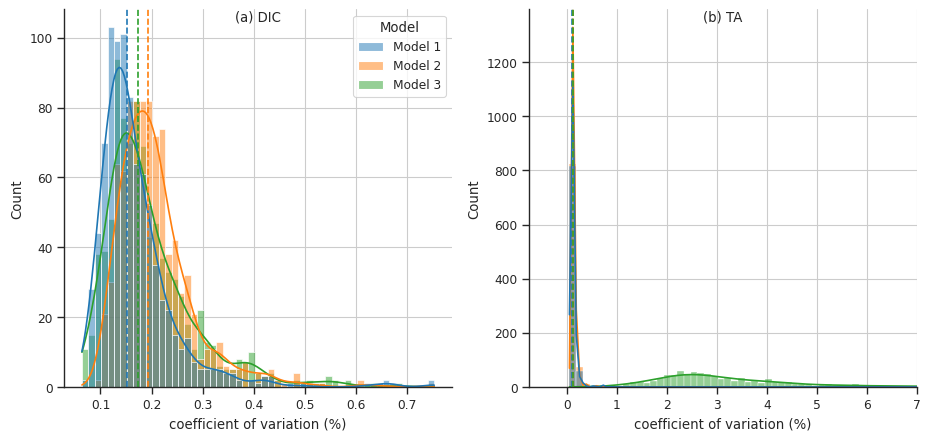

In [27]:
for df in [df_uncert, df_uncert_noO2, df_uncert_no_sat]:
    df['cv_DIC'] = df.std_DIC / df.avg_DIC * 100
    df['cv_TA'] = df.std_TA / df.avg_TA * 100

df_dic = pd.DataFrame({'Model 1': df_uncert['cv_DIC'],
                       'Model 2': df_uncert_noO2['cv_DIC'],
                       'Model 3': df_uncert_no_sat['cv_DIC']})
df_ta = pd.DataFrame({'Model 1': df_uncert['cv_TA'],
                      'Model 2': df_uncert_noO2['cv_TA'],
                      'Model 3': df_uncert_no_sat['std_TA']})

df_dic2 = pd.melt(df_dic, value_vars=['Model 1','Model 2','Model 3']).rename(columns={'variable':'Model', 'value':'cv'})
df_ta2 = pd.melt(df_ta, value_vars=['Model 1','Model 2','Model 3']).rename(columns={'variable':'Model', 'value':'cv'})

cdic = [df.cv_DIC.median() for df in [df_uncert, df_uncert_noO2, df_uncert_no_sat]]
cta = [df.cv_TA.median() for df in [df_uncert, df_uncert_noO2, df_uncert_no_sat]]

fig, axs = plt.subplots(1, 2, figsize=(11, 5))
_ = sns.histplot(x='cv', data=df_dic2, hue='Model', kde=True, bins=55, ax=axs[0], legend=True)
_ = sns.histplot(x='cv', data=df_ta2, hue='Model', kde=True, bins=100, ax=axs[1], legend=False)
_ = axs[1].set_xlim(-0.755, 7)
for md, c in zip(cdic, ['C0','C1','C2']):
    _ = axs[0].axvline(md, c=c, ls='--')
for md, c in zip(cta, ['C0','C1','C2']):
    _ = axs[1].axvline(md, c=c, ls='--')
for ax, lab in zip(axs.ravel(), ['(a) DIC', '(b) TA']):
    _ = ax.text(0.5, 0.97, '{}'.format(lab), transform=ax.transAxes, ha='center')
    _ = ax.set(xlabel='coefficient of variation (%)')
sns.despine(fig)

In [28]:
# cdic, cta